# Fine Tuning

# Load Dataset

In [1]:
import pandas as pd

train_data = pd.read_csv('train_data.csv')
validation_data = pd.read_csv('validation_data.csv')
test_data = pd.read_csv('test_data.csv')
print(train_data.head())

   labels                                              input
0       3  Lots of fun stuff!: This box was stuffed full ...
1       4  Where is the link to subscribe for 8-13?: We l...
2       4  Worth it!: Loved everything in there, definite...
3       4                Educational!: My grandkids love it!
4       4  Great small company to support: I love these b...


# Visualize the Distribution

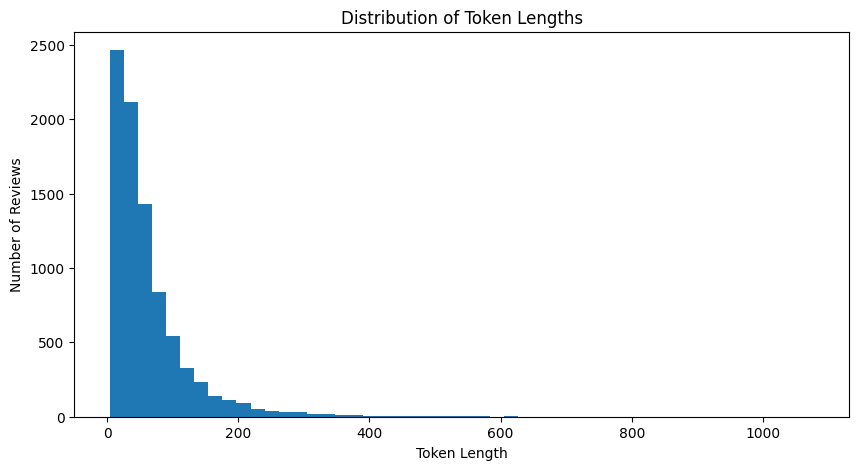

In [4]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")
token_lengths = []
for review in train_data['input']:
    tokens = tokenizer.encode(review)
    token_lengths.append(len(tokens))

lengths_df = pd.DataFrame(token_lengths, columns=['lengths'])
plt.figure(figsize=(10, 5))
plt.hist(lengths_df['lengths'], bins=50)
plt.title('Distribution of Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Number of Reviews')
plt.show()

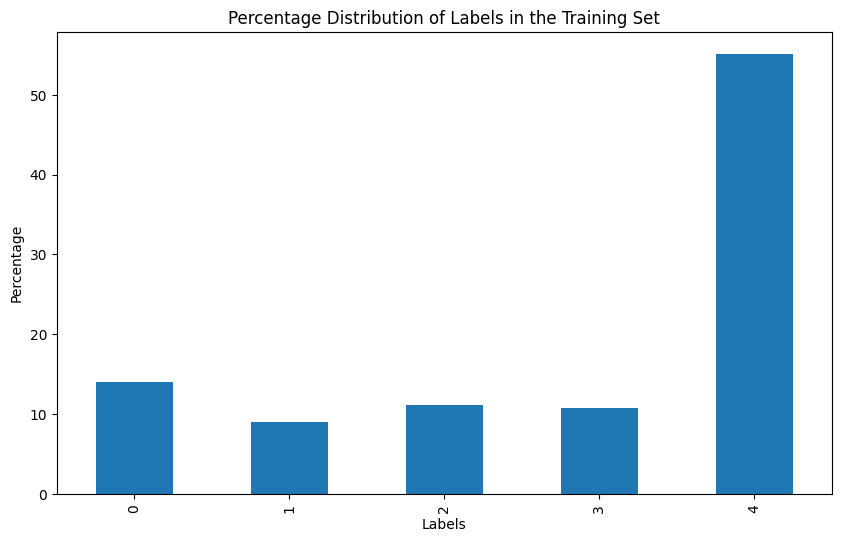

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

label_counts = train_data['labels'].value_counts()
label_percentages = label_counts / label_counts.sum() * 100
label_percentages = label_percentages.sort_index()

plt.figure(figsize=(10, 6))
label_percentages.plot(kind='bar')
plt.title('Percentage Distribution of Labels in the Training Set')
plt.xlabel('Labels')
plt.ylabel('Percentage')
plt.show()

# Tokenize the dataset

In [2]:
print(train_data.dtypes)

labels     int64
input     object
dtype: object


In [3]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(validation_data)
test_dataset = Dataset.from_pandas(test_data)

In [5]:
def preprocess_function(examples):
    return tokenizer(examples['input'], truncation=True, padding='max_length', max_length=128)

train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/8557 [00:00<?, ? examples/s]

Map:   0%|          | 0/2852 [00:00<?, ? examples/s]

Map:   0%|          | 0/2853 [00:00<?, ? examples/s]

# Load  the pre-trained model

In [6]:
from transformers import AutoModelForSequenceClassification

num_labels = len(train_data['labels'].unique())
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels=num_labels, problem_type="single_label_classification")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Set parameters for training

In [8]:
import numpy as np
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
np.object = object
np.bool = bool
np.int = int
from transformers import Trainer, TrainingArguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    save_strategy="epoch",
    load_best_model_at_end=True
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'accuracy': (predictions == labels).mean()}
    
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)


# Training

In [9]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.851600,0.731490,0.710028
2,0.669100,0.741340,0.718794
3,0.581800,0.723807,0.727560
4,0.496100,0.779604,0.721248
5,0.426200,0.862836,0.710729
6,0.341400,0.966663,0.706522
7,0.279800,1.117675,0.691795
8,0.240300,1.171044,0.706171
9,0.202200,1.276234,0.706522
10,0.167200,1.311038,0.705119


TrainOutput(global_step=5350, training_loss=0.40666257911753434, metrics={'train_runtime': 1726.6279, 'train_samples_per_second': 49.559, 'train_steps_per_second': 3.099, 'total_flos': 5628754862661120.0, 'train_loss': 0.40666257911753434, 'epoch': 10.0})

# Testing

In [10]:
results = trainer.evaluate(test_dataset)
print(results)

{'eval_loss': 0.6851500868797302, 'eval_accuracy': 0.7360672975814931, 'eval_runtime': 15.359, 'eval_samples_per_second': 185.754, 'eval_steps_per_second': 11.654, 'epoch': 10.0}


In [11]:
model_path = "./fine_tune"
trainer.save_model(model_path)

In [ ]:
import torch
import torch.nn as nn

In [18]:
label_weights = 1/label_percentages
label_weights = torch.tensor(label_weights, dtype=torch.float)

In [19]:
model = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels=num_labels, problem_type="single_label_classification")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
from transformers import Trainer, TrainingArguments
import torch
import torch.nn as nn

class MyTrainer(Trainer):
    def __init__(self, model, args, train_dataset, eval_dataset, compute_metrics, class_weights, **kwargs):
        super().__init__(model=model, args=args, train_dataset=train_dataset, eval_dataset=eval_dataset, compute_metrics=compute_metrics, **kwargs)
        
        # 确保权重在正确的设备上（model.device 通常是模型所在的设备，例如 'cuda:0'）
        if class_weights is not None:
            class_weights = class_weights.to(model.device)
        self.loss_fct = nn.CrossEntropyLoss(weight=class_weights)

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        
        loss = self.loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# 使用你的model和label_weights初始化MyTrainer
trainer = MyTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    class_weights=label_weights  # 确保label_weights已经定义
)


In [26]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.146500,1.005159,0.707924
2,0.943300,1.013964,0.680224
3,0.816200,1.084073,0.665498
4,0.670800,1.198366,0.693548
5,0.569200,1.319682,0.675316
6,0.444500,1.496857,0.680575
7,0.345300,1.725403,0.670407
8,0.279800,1.901158,0.690743
9,0.206300,2.097242,0.698808
10,0.169200,2.143622,0.705119


TrainOutput(global_step=5350, training_loss=0.5323805464985215, metrics={'train_runtime': 1778.517, 'train_samples_per_second': 48.113, 'train_steps_per_second': 3.008, 'total_flos': 5628754862661120.0, 'train_loss': 0.5323805464985215, 'epoch': 10.0})

In [27]:
results = trainer.evaluate(test_dataset)
print(results)

{'eval_loss': 0.9706053137779236, 'eval_accuracy': 0.7181913774973712, 'eval_runtime': 14.772, 'eval_samples_per_second': 193.136, 'eval_steps_per_second': 12.118, 'epoch': 10.0}


In [27]:
model_path = "./fine_tune_imbalance"
trainer.save_model(model_path)

{'eval_loss': 0.9706053137779236, 'eval_accuracy': 0.7181913774973712, 'eval_runtime': 14.772, 'eval_samples_per_second': 193.136, 'eval_steps_per_second': 12.118, 'epoch': 10.0}
